# Variational simulation study
## Setup

In [2]:
import yaml
import json
import pymc3 as pm
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sys
import os
import templating
import variational_analysis
import subprocess
import process_results
import pipeline

/usr/lib/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('config.yaml') as f:
    config = yaml.load(f)

config

{'beast_jar': 'lib/feast.jar',
 'burn_in': 0.1,
 'chain_length': 2000000,
 'cluster_type': 'neighborjoining2',
 'cluster_with_dates': True,
 'estimate_clock_rate': False,
 'estimate_topology': False,
 'frequencies': [0.24, 0.26, 0.26, 0.24],
 'inference': 'mean_field',
 'init_values': {'clock_rate': 1.0, 'kappa': 2.0, 'pop_size': 1000},
 'kappa': 2.0,
 'log_every': 100,
 'mutation_rate': 0.001,
 'n_eval_samples': 200,
 'n_iter': 20000,
 'n_runs': 3,
 'n_taxa': 20,
 'n_trace_samples': 1000,
 'nuts_draws': 10000,
 'nuts_tune': 100,
 'out_dir': 'out/0',
 'prior_params': {'clock_rate': {'m': 1.0, 's': 1.25},
  'kappa': {'m': 1.0, 's': 1.25},
  'pop_size': {'m': 2, 's': 0.1}},
 'rate_sd': None,
 'relaxed_clock': False,
 'sampling_window': 20,
 'seed': 1,
 'sequence_length': 1000}

In [4]:
pipeline.do_seeding(config)
out_dir = config['out_dir']
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
build_templates = templating.TemplateBuilder(out_dir)

## Simulation

### Population size

array([6.07391639, 8.98895318])

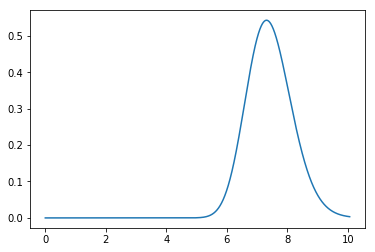

In [5]:
pop_size_prior = scipy.stats.lognorm(scale=np.exp(config['prior_params']['pop_size']['m']), s=config['prior_params']['pop_size']['s'])
xs = np.arange(0, pop_size_prior.ppf(0.999), 0.001)
plt.plot(xs, pop_size_prior.pdf(xs));
pop_size_prior.ppf([0.025, 0.975])

In [6]:
beast_args = ['java'] + pipeline.cmd_kwargs(jar=config['beast_jar'], seed=config['seed']) + ['-overwrite']
pop_size, taxon_names, date_trait_string = build_templates.build_tree_sim(config)
pop_size

8.692273576071088

### Sampling times

18.863292844056232

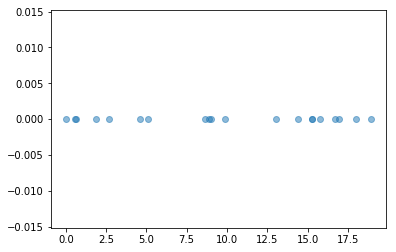

In [7]:
import statsmodels
sampling_times = [float(x.split('=')[1]) for x in date_trait_string.split(',')]
plt.scatter(sampling_times, np.zeros_like(sampling_times), alpha=0.5);
np.max(sampling_times) - np.min(sampling_times)

### Tree simulation

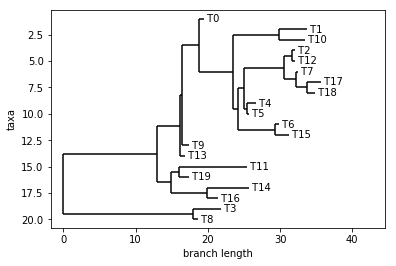

35.67151

In [22]:
import Bio
from io import StringIO

subprocess.run(beast_args + [build_templates.tree_sim_out_path])
newick_string = build_templates.extract_newick_string(build_templates.tree_sim_result_path)
bio_tree = next(Bio.Phylo.parse(StringIO(newick_string), 'newick'))
Bio.Phylo.draw(bio_tree)
tree_height = max(bio_tree.depths().values())
tree_height

### Sequence simulation